# Background story

You are currently getting a new project from the **inventory team** and **marketing team**.
<img src="image/forecast.png" width="200">
<img src="image/customer segmentation.jpg" width="200">
- From the **inventory team**, you are asked to help predicting the number of sales (quantity) from the total all Kalbe products.
    - The goal of this project is to estimate the quantity of products sold so that the team inventory can create daily inventory sufficiently.
    - Predictions must be made daily.
- From the **marketing team** you are asked to create customer clusters/segments based on several criteria.
    - The goal of this project is to create segment customers.
    - This customer segment will later be used by marketing team to provide personalization promotions and sales treatment.


**Challenge**:
1. SQL Query
    - query 1: What is the average of customer age for each marital status?
    - query 2: What is the average of customer age for each gender?
    - query 3: Identify the name of the shop with the highest total quantity!
    - query 4: Identify the name of the best-selling product with the highest total amount!
2. Tableau Dashboard
    - Worksheet 1: The number of monthly quantity.
    - Worksheet 2: The number of daily total amount.
    - Worksheet 3: The number of quantity by product.
    - Worksheet 4: The number of total amount by store name.

## Table of Content

- [Load dataset and import libraries](#1)
- [Data understanding](#2)
    - [Check data types, missing values, and duplicates](#2-1)
    - [Data joining](#2-2)
- [Challenge](#3)
    - [SQL query](#3-1)
    - [Tableau dashboard](#3-2)
- [Customer segmentation](#4)
    - [Customer profile dataset](#4-1)
    - [Exploratory Data Analysis](#4-2)
        - [Univariate analysis](#4-2-1)
            - [Outliers removal](#4-2-1-1)
        - [Multivariate analysis](#4-2-2)
            - [Pairplot and p-correleation](#4-2-2-1)
            - [Hypothesis testing](#4-2-2-2)
    - [Data preprocessing](#4-3)
    - [Modeling - clustering](#4-4)
        - [Behavioral segmentation](#4-4-1)
            - [Find the best number of clusters](#4-4-1-1)
            - [Build and interpret clustering model](#4-4-1-2)
        - [Demographic segmentation](#4-4-2)
            - [Find the best number of clusters](#4-4-2-1)
            - [Build and interpret clustering model](#4-4-2-2)
    - [Assign the results to customer dataset](#4-5)
    - [Dashbord - Sales Analysis by Customer Segmentation](#4-6)
- [Forecasting](#5)
    - [Daily quantity dataset](#5-1)
    - [Check for stationarity](#5-2)
    - [Define the best p and q parameters](#5-3)
    - [Choose the best model using grid search](#5-4)
    - [Build the model](#5-5)
    - [Visualize the result](#5-6)
    - [Predict the future](#5-7)
- [Recommendations](#6)
- [References](#7)

<a name='1'></a>
# Load dataset and import libraries

Dataset attributes:
1. "customer" table
    - `CustomerID` : Customer Identifier (*Primary key*)
    - `Age` : Customer Age
    - `Gender` : 0 Woman or 1 Man
    - `Marital Status` : Married or Single
    - `Income` : Monthly Income in Million IDR
2. "product" table
    - `ProductID` : Product Identifier (*Primary key*)
    - `Product Name` : Product Name
    - `Price` : Price in IDR
3. "store" table   
    - `StoreID` : Store Identifier (*Primary key*)
    - `StoreName` : Store Name
    - `GroupStore` : Group Name
    - `Type` : Modern Trade or General Trade
    - `Latitude` : Latitude
    - `Longitude` : Longitude
4. "transaction" table
    - `TransactionID` : Transaction Identifier (*Primary key*)
    - `CustomerID` : Customer Identifier (*Foreign key*)
    - `ProductID` : Product Identifier (*Foreign key*)
    - `StoreID` : Store Identifier (*Foreign key*)
    - `Date` : Transaction Date
    - `Price`: Product Price
    - `Qty` : Product Quantity
    - `TotalAmount` : Price x Qty

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the dataset
customer = pd.read_csv('dataset/Case Study - Customer.csv', sep = ';')
product = pd.read_csv('dataset/Case Study - Product.csv', sep = ';')
store = pd.read_csv('dataset/Case Study - Store.csv', sep = ';')
transaction = pd.read_csv('dataset/Case Study - Transaction.csv', sep = ';')
transaction = transaction[['TransactionID', 'CustomerID', 'ProductID', 'StoreID', 'Date', 'Price', 'Qty', 'TotalAmount']]

<a name = '2'></a>

# Data understanding

In [3]:
def check_dataset(df, name, identifier):
    print('='*40, name, 40*'=')
    print('The number of unique "{}": {}\n'.format(identifier, df[identifier].nunique()))
    df.info()
    display(df)

<a name = '2-1'></a>
## Check data types, missing values, and duplicates

##### customer DataFrame

- No duplicates
- `CustomerID`
    - Convert to object
- `Marital Status`
    - 3 missing values &rarr; impute using mode
- `Income`
    - Convert to float

In [4]:
# customer df
check_dataset(customer, 'customer', 'CustomerID')

======================================== customer ========================================
The number of unique "CustomerID": 447

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"
...,...,...,...,...,...
442,443,33,1,NaN,"9,28"
443,444,53,0,Married,"15,31"
444,445,51,0,Married,"14,48"
445,446,57,0,Married,"7,81"


In [5]:
# clean customer df
customer['Income'] = customer['Income'].str.replace(',','.')
customer = customer.astype({'CustomerID':'object',
                            'Income':'float64'})                            
customer = customer.fillna({'Marital Status':customer['Marital Status'].mode()[0]})

##### product DataFrame

- All seem good

In [6]:
# product df
check_dataset(product, 'product', 'ProductID')

======================================== product ========================================
The number of unique "ProductID": 10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200
5,P6,Cashew,18000
6,P7,Coffee Candy,9400
7,P8,Oat,16000
8,P9,Yoghurt,10000
9,P10,Cheese Stick,15000


##### store DataFrame

- `StoreID`
    - Convert to object
- `Latitude` and `Longitude`
    - Convert to numeric

In [7]:
# store df
check_dataset(store, 'store', 'StoreID')

======================================== store ========================================
The number of unique "StoreID": 14

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"
5,6,Lingga,Lingga,Modern Trade,"-5,135399","119,42379"
6,7,Buana Indah,Buana,General Trade,"3,316694","114,590111"
7,8,Sinar Harapan,Harapan Baru,General Trade,"5,54829","95,323753"
8,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
9,10,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513"


In [8]:
# clean store df
store['Latitude'] = store['Latitude'].str.replace(',','.')
store['Longitude'] = store['Longitude'].str.replace(',','.')
store = store.astype({'StoreID':'object',
                      'Latitude':'float64',
                      'Longitude':'float64'})

##### transaction DataFrame

- `TransactionID`
    - There might be some duplicates &rarr; total rows data != the number of unique ID
- `CustomerID` and `StoreID`
    - Convert to object
- `Date`
    - Convert to datetime

In [9]:
# transaction df
check_dataset(transaction, 'transaction', 'TransactionID')

======================================== transaction ========================================
The number of unique "TransactionID": 4908

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   ProductID      5020 non-null   object
 3   StoreID        5020 non-null   int64 
 4   Date           5020 non-null   object
 5   Price          5020 non-null   int64 
 6   Qty            5020 non-null   int64 
 7   TotalAmount    5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


,TransactionID,CustomerID,ProductID,StoreID,Date,Price,Qty,TotalAmount
0,TR11369,328,P3,12,01/01/2022,7500,4,30000
1,TR16356,165,P9,1,01/01/2022,10000,7,70000
2,TR1984,183,P1,4,01/01/2022,8800,4,35200
3,TR35256,160,P1,4,01/01/2022,8800,7,61600
4,TR41231,386,P9,4,01/01/2022,10000,1,10000
...,...,...,...,...,...,...,...,...
5015,TR54423,243,P10,3,31/12/2022,15000,5,75000
5016,TR5604,271,P2,9,31/12/2022,3200,4,12800
5017,TR81224,52,P7,9,31/12/2022,9400,6,56400
5018,TR85016,18,P8,13,31/12/2022,16000,3,48000


In [10]:
# check duplicates
transaction[transaction.duplicated(subset = ['TransactionID'], keep = False)].sort_values('TransactionID')

,TransactionID,CustomerID,ProductID,StoreID,Date,Price,Qty,TotalAmount
1655,TR11542,374,P10,4,29/04/2022,15000,4,60000
3022,TR11542,286,P8,8,07/08/2022,16000,1,16000
574,TR12602,338,P2,2,11/02/2022,3200,7,22400
2079,TR12602,154,P7,13,30/05/2022,9400,6,56400
3575,TR1280,60,P10,2,17/09/2022,15000,5,75000
...,...,...,...,...,...,...,...,...
4233,TR96509,39,P3,12,03/11/2022,7500,3,22500
495,TR96549,252,P5,3,04/02/2022,4200,4,16800
1878,TR96549,96,P8,7,14/05/2022,16000,2,32000
2953,TR99533,314,P6,3,31/07/2022,18000,2,36000


- Duplicates of `TransactionID` are found but each of them has different `CustomerID` and different `Date`. There might be an error in data entry for `TransactionID`. For now we will just left it behind because that column is not our focus and it won't be matter.

In [11]:
# clean transaction df
transaction = transaction.astype({'CustomerID':'object',
                                  'StoreID':'object',
                                  'Date':'datetime64'})

<a name = '2-2'></a>
## Data joining 

Joining "transaction" DataFrame with "customer", "product", and "store" DataFrames, and storing all joined DataFrame to `df` variable.

In [12]:
# join all dataset
df = transaction.merge(customer, how = 'left', on = 'CustomerID')\
                .merge(product, how = 'left', on = 'ProductID', suffixes = ('_trx', '_product'))\
                .merge(store, how = 'left', on = 'StoreID').rename({'Price_product':'Price'}, axis = 1).drop('Price_trx', axis = 1)

# reorder column names
columns = ['Date', 'TransactionID'] + customer.columns.tolist() + store.columns.tolist() + product.columns.tolist() + ['Qty', 'TotalAmount']
df = df[columns]
df = df.set_index('Date')
df.to_csv('dataset/transaction (joined).csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5020 entries, 2022-01-01 to 2022-12-31
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TransactionID   5020 non-null   object 
 1   CustomerID      5020 non-null   object 
 2   Age             5020 non-null   int64  
 3   Gender          5020 non-null   int64  
 4   Marital Status  5020 non-null   object 
 5   Income          5020 non-null   float64
 6   StoreID         5020 non-null   object 
 7   StoreName       5020 non-null   object 
 8   GroupStore      5020 non-null   object 
 9   Type            5020 non-null   object 
 10  Latitude        5020 non-null   float64
 11  Longitude       5020 non-null   float64
 12  ProductID       5020 non-null   object 
 13  Product Name    5020 non-null   object 
 14  Price           5020 non-null   int64  
 15  Qty             5020 non-null   int64  
 16  TotalAmount     5020 non-null   int64  
dtypes: float64(3), 

,TransactionID,CustomerID,Age,Gender,Marital Status,Income,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,ProductID,Product Name,Price,Qty,TotalAmount
Date,,,,,,,,,,,,,,,,,
2022-01-01,TR11369,328,36,0,Married,10.53,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,P3,Crackers,7500,4,30000
2022-01-01,TR16356,165,44,1,Married,14.58,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,P9,Yoghurt,10000,7,70000
2022-01-01,TR1984,183,27,1,Single,0.18,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,P1,Choco Bar,8800,4,35200
2022-01-01,TR35256,160,48,1,Married,12.57,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,P1,Choco Bar,8800,7,61600
2022-01-01,TR41231,386,33,0,Married,6.95,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,P9,Yoghurt,10000,1,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,TR54423,243,38,0,Married,3.34,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529,P10,Cheese Stick,15000,5,75000
2022-12-31,TR5604,271,29,0,Married,4.74,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,P2,Ginger Candy,3200,4,12800
2022-12-31,TR81224,52,37,0,Married,3.73,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,P7,Coffee Candy,9400,6,56400


<a name = '3'></a>
# Challenge

<a name = '3-1'></a>
## SQL query

- query 1: What is the average of customer age for each marital status?
- query 2: What is the average of customer age for each gender?
- query 3: Identify the name of the shop with the highest total quantity!
- query 4: Identify the name of the best-selling product with the highest total amount!

You can download the query script file via this [link](https://drive.google.com/drive/folders/1gmqLjpqN4GS5GqPg32hO-QB0Oixt5ex-?usp=sharing).

<a name = '3-2'></a>
## Tableau dashboard

- Worksheet 1: The number of monthly quantity.
- Worksheet 2: The number of daily total amount.
- Worksheet 3: The number of quantity by product.
- Worksheet 4: The number of total amount by store name.

You can see or download the dashboard on Tableau Public via this [link](https://public.tableau.com/views/Challenge_16954683258160/Dashboard1?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link).

<a name = '4'></a>
# Customer segmentation

<a name = '4-1'></a>
## Customer profile dataset

Creating customer profiles dataset by characterizing them based on their behavioral and demographic data, then storing the new dataset to `df_clustering` variable containing information about:
1. Behavioral data
    - Number of transactions. (count of `TransactionID`)
    - Total Quantity. (sum of `Qty`)
    - Total Amount Sales. (sum of `TotalAmount`)
    - Number of days since last transaction. (now - last transaction `Date`)
2. Demographic data
    - Age
    - Gender
    - Marital Status
    - Income

In [13]:
import datetime as dt
current_date = df.index.max() + dt.timedelta(days = 1)
print('Last transaction datetime:', df.index.max())
print('Hypothetical current datetime:', current_date)

# create clustering dataset
df_clustering = df.reset_index().groupby('CustomerID').agg(Frequency = ('TransactionID', 'count'),
                                                           Total_Quantity = ('Qty', 'sum'),
                                                           Total_Amount_Sales = ('TotalAmount', 'sum'),
                                                           Recency = ('Date', lambda x: (current_date - x.max()).days))
df_clustering = df_clustering.merge(customer.set_index('CustomerID'), how = 'left', left_index = True, right_index = True)
df_clustering['Gender'] = df_clustering['Gender'].replace({1:'Man', 0:'Woman'})
df_clustering

Last transaction datetime: 2022-12-31 00:00:00
Hypothetical current datetime: 2023-01-01 00:00:00


,Frequency,Total_Quantity,Total_Amount_Sales,Recency,Age,Gender,Marital Status,Income
CustomerID,,,,,,,,
1,17,60,623300,53,55,Man,Married,5.12
2,13,57,392300,97,60,Man,Married,6.23
3,15,56,446200,10,32,Man,Married,9.17
4,10,46,302500,5,31,Man,Married,4.87
5,7,27,268600,91,58,Man,Married,3.57
...,...,...,...,...,...,...,...,...
443,16,59,485100,63,33,Man,Married,9.28
444,18,62,577700,38,53,Woman,Married,15.31
445,18,68,587200,42,51,Woman,Married,14.48


<a name = '4-2'></a>
## Exploratory Data Analysis

In [14]:
num = ['Frequency', 'Total_Quantity', 'Total_Amount_Sales', 'Recency', 'Age', 'Income']
cat = [col for col in df_clustering.columns if col not in num]

# helper function to plot data distribution of numerical columns
def check_dist_num(input_data, columns):
    fig = plt.figure(figsize = (25, 25))
    i = 1
    for col in input_data[columns].columns:
        plt.subplot(6, 6, i)
        ax = sns.boxplot(x = input_data[col], color = '#90B77D')
        ax.set(xlabel = None, ylabel = None)
        plt.title(str(col), loc = 'center', fontsize = 16)
        plt.xticks(rotation = 20, fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.tight_layout()
        i += 1
    plt.show()

    fig = plt.figure(figsize = (25, 25))
    i = 1
    for col in input_data[columns].columns:
        plt.subplot(6, 6, i)
        ax = sns.distplot(x = input_data[col], color = '#90B77D')
        ax.set(xlabel = None, ylabel = None)
        plt.title(str(col), loc = 'center', fontsize = 16)
        plt.xticks(rotation = 20, fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.tight_layout()
        i += 1
    plt.show()
    
# helper function to plot data distribution of categorical columns
def check_dist_cat(input_data, columns):
    fig = plt.figure(figsize = (15, 11))
    i = 1
    for col in input_data[columns].columns:
        plt.subplot(5, 5, i)
        ax = sns.countplot(data = input_data[columns], y = input_data[col], palette = 'tab20')
        ax.set(xlabel = None, ylabel = None)
        plt.title(str(col), loc = 'center', fontsize = 10)
        plt.xticks(rotation = 0, fontsize = 8)
        plt.yticks(fontsize = 8)
        plt.tight_layout()
        i += 1
    plt.show()

<a name = '4-2-1'></a>
### Univariate analysis

- `Recency` and `Income` have skewed distribution to the right. Other than those are close to normal distribution.
    - *Removing outliers or doing data transformation for `Recency` and `Income` might help us to make the distribution look normal*.
- Minimum value of `Age` is 0 which is not reasonable. 
    - *Need to be examined and validated*.
- Minimum value of `Income` is 0, but this might happen when the customers are not employed.
    - *Need to be examined and validated*.
- "Married" customers are more dominant.
- Both `Gender` values are quite equal.

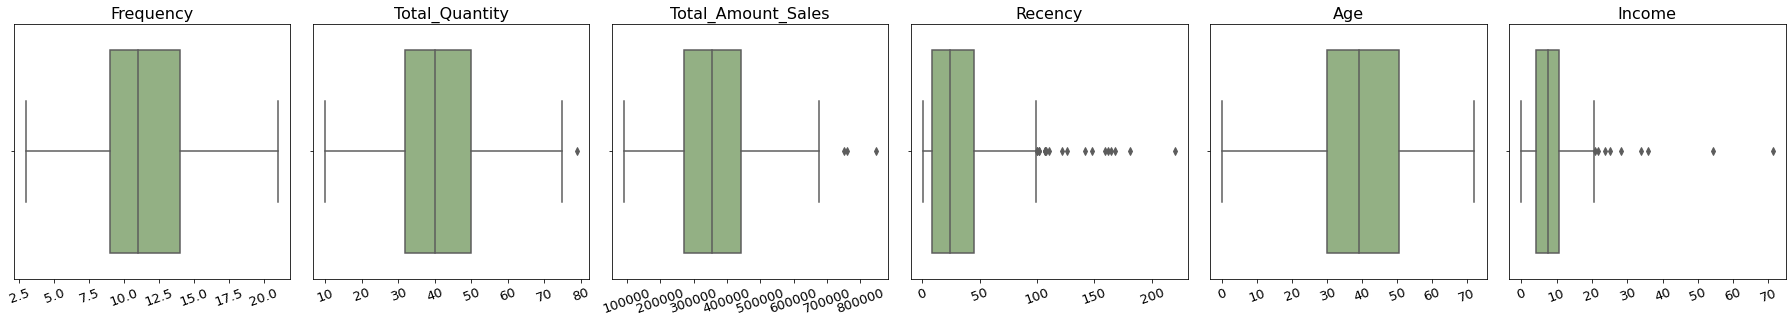

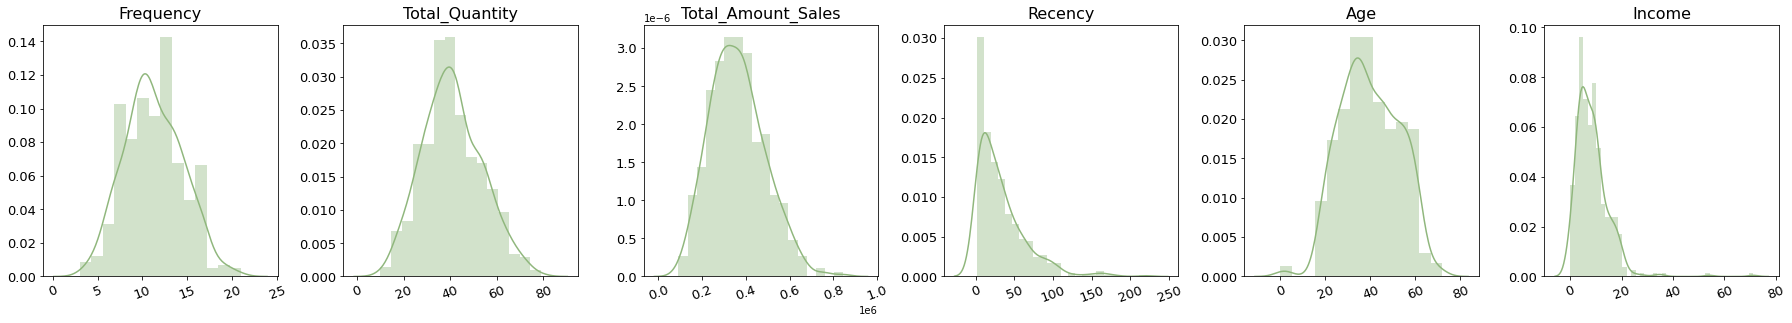

,count,mean,std,min,25%,50%,75%,max
Frequency,447.0,11.230425,3.245302,3.0,9.000,11.00,14.00,21.0
Total_Quantity,447.0,40.930649,12.756679,10.0,32.000,40.00,50.00,79.0
Total_Amount_Sales,447.0,362512.304251,124634.279184,92100.0,271750.000,354200.00,441200.00,846700.0
Recency,447.0,32.756152,32.133913,1.0,9.000,24.00,45.00,220.0
Age,447.0,39.782998,12.848719,0.0,30.000,39.00,50.50,72.0
Income,447.0,8.592103,6.607065,0.0,4.175,7.52,10.81,71.3


In [15]:
# numerical columns
check_dist_num(df_clustering, num)
df_clustering[num].describe().T

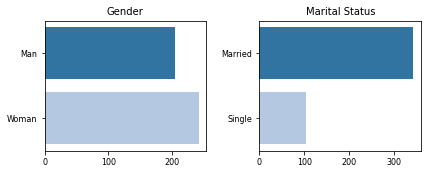

,count,unique,top,freq
Gender,447,2,Woman,242
Marital Status,447,2,Married,343


In [16]:
# categorical columns
check_dist_cat(df_clustering, cat)
df_clustering[cat].describe().T

<a name = '4-2-1-1'></a>
#### Outliers removal

Handling the outliers and storing the dataset to `df_clustering_no_outliers` variable.

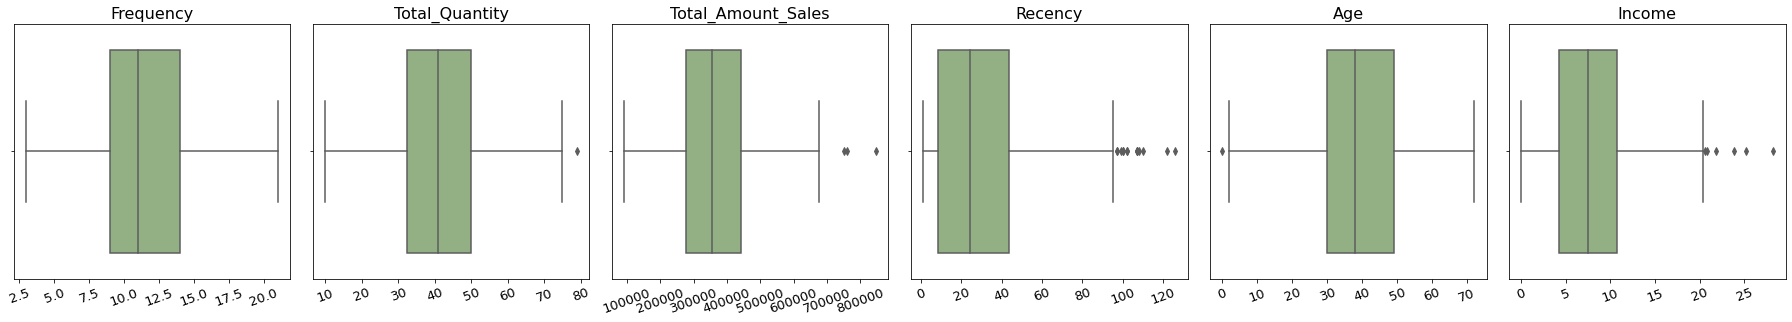

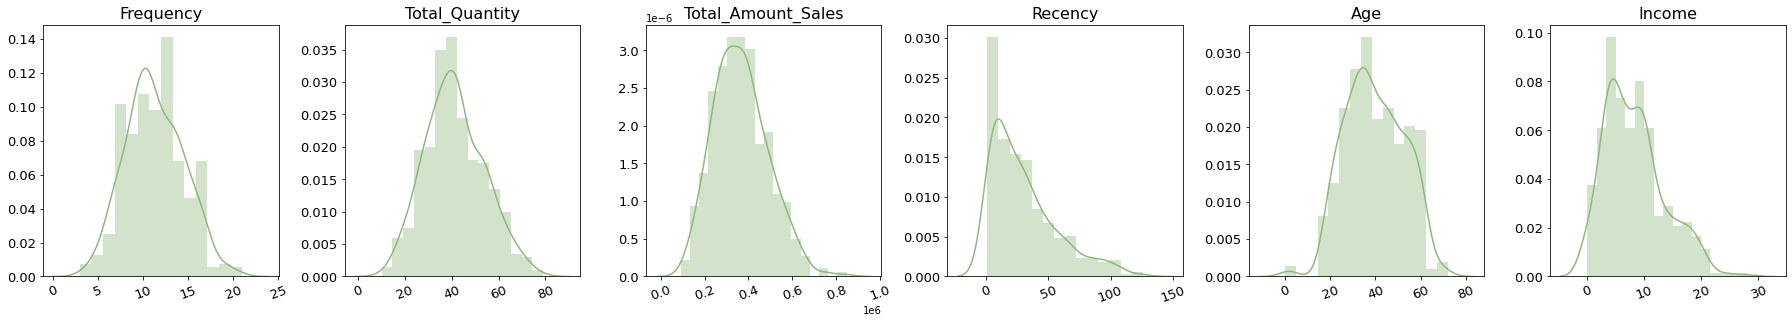

In [17]:
# helper function to remove outlier with z-score method
def z_score_outliers(input_data, column):
    upper_bound = input_data[column].mean() + 3*input_data[column].std()
    lower_bound = input_data[column].mean() - 3*input_data[column].std()
    output_data = input_data[(input_data[column] < upper_bound) & (input_data[column] > lower_bound)]
    return output_data

# remove outliers in 'Income' and 'Recency' so that they are not too skewed
df_clustering_no_outliers = z_score_outliers(df_clustering, 'Income')
df_clustering_no_outliers = z_score_outliers(df_clustering_no_outliers, 'Recency')

# check the distribution again
check_dist_num(df_clustering_no_outliers, num)

In [18]:
# check outliers for 'Income' == 0
print(35*'=', 'Zero Income Customers', 35*'=')
income_is_0 = df_clustering_no_outliers[df_clustering_no_outliers['Income'] == 0]
display(income_is_0)

# check outliers for 'Age' < 18 years old
print(35*'=', 'Customers with Age < 18', 35*'=')
age_less_18 = df_clustering_no_outliers[df_clustering_no_outliers['Age'] < 18]
display(age_less_18)

=================================== Zero Income Customers ===================================


,Frequency,Total_Quantity,Total_Amount_Sales,Recency,Age,Gender,Marital Status,Income
CustomerID,,,,,,,,
67,14,57,442600,9,19,Woman,Single,0.0
90,10,38,367800,25,21,Man,Single,0.0
164,13,40,296700,5,18,Man,Single,0.0
226,8,37,381600,63,18,Woman,Single,0.0
252,10,35,278000,5,18,Man,Single,0.0
267,12,47,378000,9,22,Woman,Single,0.0
283,17,61,499400,21,19,Man,Single,0.0
285,13,42,277000,85,20,Woman,Single,0.0
288,10,35,340800,12,22,Woman,Single,0.0


=================================== Customers with Age < 18 ===================================


,Frequency,Total_Quantity,Total_Amount_Sales,Recency,Age,Gender,Marital Status,Income
CustomerID,,,,,,,,
12,16,61,582500,28,2,Man,Married,4.94
74,6,21,181600,28,3,Man,Married,5.09
128,9,30,294600,4,0,Man,Married,6.77


- 0 `Income` customers corresponding to teenage customers are reasonable. We can just ignore this value.
- 3 customers of `Age` 0, 2, and 3 years are found. Moreover they have non-zero `Income`, have already been married, and are men.
    - Impute them with the average of `Age` grouped by `Gender` - "Man" and `Marital Status` - "Married".

In [19]:
# compute the average 'Age' group by 'Gender' and 'Marital Status'
avg_age = df_clustering_no_outliers.groupby(['Gender', 'Marital Status'])[['Age']].mean().round().astype(int)

# take the average age for married man
impute_avg_age = avg_age.loc[('Man', 'Married')].values[0]

# get the index from the data we want to impute
id_cust = age_less_18.index

# impute the average age
df_clustering_no_outliers.loc[id_cust, ['Age']] = impute_avg_age

<a name = '4-2-2'></a>
### Multivariate analysis

<a name = '4-2-2-1'></a>
#### Pairplot and p-correlation

- The difference in mean between "Man" and "Woman" (`Gender`) to each numerical feature (e.g. `Frequency`, `Total_Quantity`, `Total_Amount_Sales`, `Recency`, `Age`, or `Income`) is relatively small.
    - *Need to examine whether the difference is significant or not*.
- The difference in mean between "Married" and "Single" (`Marital Status`) to numerical features such as `Recency`, `Age`, and `Income` is quite moderate, meanwhile for `Frequency`, `Total_Quantity`, and `Total_Amount_Sales` is relatively small.
    - *Need to examine whether the difference is significant or not*.
- There is a strong linear relationship between the pair of `Frequency`, `Total_Quantity`, and `Total_Amount_Sales`.
- There is a moderate linear relationship between the pair of `Income`, `Marital Status`, and `Age`.



========================= Relationship of numerical variables and 'Gender' =========================


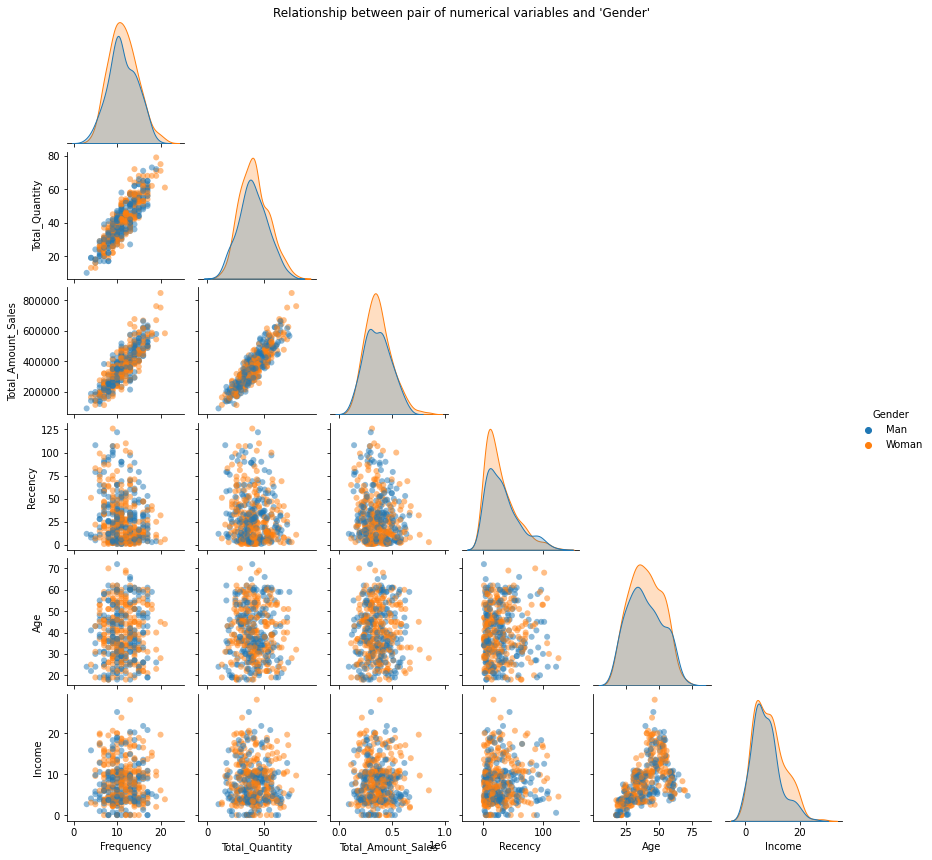

,Frequency,Total_Quantity,Total_Amount_Sales,Recency,Age,Income
Gender,,,,,,
Man,11.209184,40.658163,361528.571429,32.244898,39.591837,7.626429
Woman,11.376569,41.715481,369482.426778,28.506276,40.154812,8.760000


========================= Relationship of numerical variables and 'Marital Status' =========================


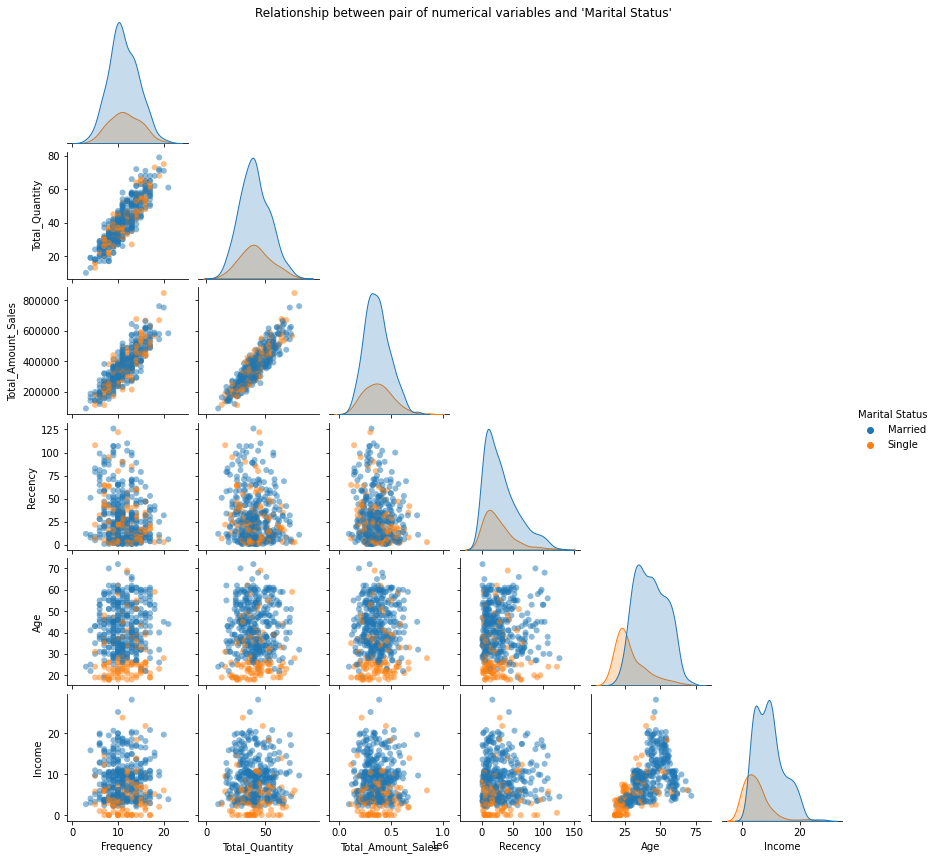

,Frequency,Total_Quantity,Total_Amount_Sales,Recency,Age,Income
Marital Status,,,,,,
Married,11.222222,41.027027,363844.144144,31.270270,43.162162,9.346847
Single,11.558824,41.931373,372605.882353,26.666667,29.254902,4.665882


In [20]:
print('='*25, "Relationship of numerical variables and 'Gender'", '='*25)
sns.pairplot(df_clustering_no_outliers[num + ['Gender']], hue = 'Gender', corner = True, height = 2, plot_kws = dict(marker = "o", alpha = 0.5, edgecolor = 'none'))                 
plt.suptitle("Relationship between pair of numerical variables and 'Gender'", va = 'bottom')
plt.show()
display(df_clustering_no_outliers.groupby('Gender').mean())

print('='*25, "Relationship of numerical variables and 'Marital Status'", '='*25)
sns.pairplot(df_clustering_no_outliers[num + ['Marital Status']], hue = 'Marital Status', corner = True, height = 2, plot_kws = dict(marker = "o", alpha = 0.5, edgecolor = 'none'))            
plt.suptitle("Relationship between pair of numerical variables and 'Marital Status'", va = 'bottom')
plt.show()
display(df_clustering_no_outliers.groupby('Marital Status').mean())

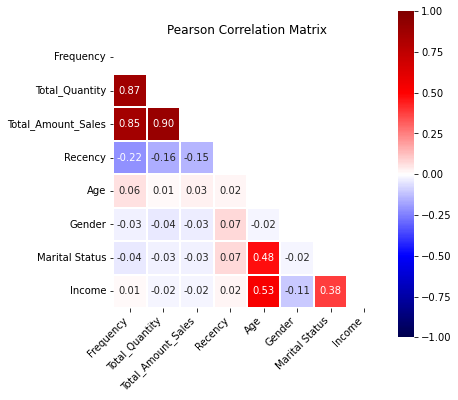

In [21]:
# pearson correlation matrix
df_corr = df_clustering_no_outliers.copy()
df_corr['Gender'] = df_corr['Gender'].replace({'Man':1, 'Woman':0})
df_corr['Marital Status'] = df_corr['Marital Status'].replace({'Married':1, 'Single':0})
df_corr = df_corr.corr()

fig, ax = plt.subplots(figsize = (6, 6))
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_corr, annot = True, fmt = '.2f', cmap = 'seismic', 
            linewidths = 0.1,  mask = mask, vmin = -1, vmax = 1, square = True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize = 10, ha = 'right', rotation = 45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize = 10, va = 'center', rotation = 0)
plt.title('Pearson Correlation Matrix')
plt.show()

<a name = '4-2-2-2'></a>
#### Hypothesis testing

From previous pairplot and p-correlation, we saw that our numerical features (such as `Income`, `Total_Quantity`, etc) have some differences in mean between "Man" and "Woman" in `Gender` or between "Single" and "Married" in `Marital Status`. So let's do some hypothesis testing in order to evaluate wheter their differences are significant or due to random chance.

In [22]:
# helper function to perform ANOVA test
import pingouin
def anova_test(df, columns, target, alpha = 0.05):
    p_value = []
    result = []
    for col in columns:
        # perform ANOVA Test
        anova_results = pingouin.anova(data = df, dv = col, between = target)
        p = anova_results['p-unc'][0]
        # assign the result and p-value
        if abs(p) <= alpha:
            result.append('reject H0 (significant)')
        else:
            result.append('fail to reject H0')
        p_value.append(p)
    output = pd.DataFrame({'p_value':p_value, 'result':result}, index = columns)
    output.index.name = '"ANOVA Test"'
    output.columns.name = target
    return output.sort_values('p_value')

In [23]:
# ANOVA test on 'Marital Status'
Marital_Status_anova = anova_test(df = df_clustering_no_outliers, 
                                  columns = ['Frequency', 'Total_Quantity', 'Total_Amount_Sales', 'Recency', 'Age', 'Income'], 
                                  target = 'Marital Status', alpha = 0.05)
Marital_Status_mean = df_clustering_no_outliers.groupby('Marital Status').mean()
pd.concat([Marital_Status_mean, Marital_Status_anova.T[Marital_Status_mean.columns]], axis = 0)

,Frequency,Total_Quantity,Total_Amount_Sales,Recency,Age,Income
Marital Status,,,,,,
Married,11.222222,41.027027,363844.144144,31.27027,43.162162,9.346847
Single,11.558824,41.931373,372605.882353,26.666667,29.254902,4.665882
p_value,0.355785,0.528961,0.532036,0.123817,0.0,0.0
result,fail to reject H0,fail to reject H0,fail to reject H0,fail to reject H0,reject H0 (significant),reject H0 (significant)


In [24]:
# ANOVA test on 'Gender'
Gender_anova = anova_test(df = df_clustering_no_outliers, 
                                  columns = ['Frequency', 'Total_Quantity', 'Total_Amount_Sales', 'Recency', 'Age', 'Income'], 
                                  target = 'Gender', alpha = 0.05)
Gender_mean = df_clustering_no_outliers.groupby('Gender').mean()
pd.concat([Gender_mean, Gender_anova.T[Gender_mean.columns]], axis = 0)

,Frequency,Total_Quantity,Total_Amount_Sales,Recency,Age,Income
Gender,,,,,,
Man,11.209184,40.658163,361528.571429,32.244898,39.591837,7.626429
Woman,11.376569,41.715481,369482.426778,28.506276,40.154812,8.76
p_value,0.589819,0.387249,0.505271,0.142231,0.638329,0.02397
result,fail to reject H0,fail to reject H0,fail to reject H0,fail to reject H0,fail to reject H0,reject H0 (significant)


- The difference in mean of `Age` or `Income` between "Single" and "Married" is statistically significant.
- The difference in mean of `Income` between "Man" and "Woman" is statistically significant.

This inform us that `Frequency`, `Total_Quantity`, `Total_Amount_Sales`, and `Recency` has no relationship with our categorical features such as `Marital Status` and `Gender`, meanwhile they have relationship with `Income` and `Age`.

<a name = '4-3'></a>
## Data preprocessing

Defining a pipeline for doing data preprocessing automatically and easily. This preprocessing pipeline includes 
- Transformation process &rarr; to transform the data distribution look like normal distribution using 'yeo-johnson' method.
- Standardization process &rarr; to scale the data to have the same range of values.
- Label encoding process &rarr; to encode non-numerical features into numerical ones.

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, FunctionTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

def get_preprocessing_pipeline(num_1 = None, num_2 = None, cat = None, cat_val = None):
    """ Function to make data preprocessing pipeline for this clustering project.
        Input:
            num_1   - Standardization process for numerical features.
            num_2   - Data transformation process using 'yeo-johnson' method for numerical features.
            cat     - Label encoding process for categorical features.
            cat_val - List of lists of each value from categorical feature.
                      For example: 
                          cat_val = [['Woman', 'Man']] 
                      This means Woman will be encoded as 0 and Man as 1.
        Return:
            pl_preprocessing - A pipeline for data preprocessing.
    """
    all_pipelines = []
    # standardization process
    if num_1 != None:      
        pl_num_1 = Pipeline([('num_1 pipeline', FunctionTransformer(lambda x: x[num_1], validate = False)),
                             ('standardization', StandardScaler())])
        all_pipelines.append(('pl standardization', pl_num_1))                        
    # transformation process
    if num_2 != None:
        pl_num_2 = Pipeline([('num_2 pipeline', FunctionTransformer(lambda x: x[num_2], validate = False)),
                             ('transformation: yeo-johnson', PowerTransformer(method = 'yeo-johnson', standardize = True))])
        all_pipelines.append(('pl transformation', pl_num_2))                        
    # label encoding process
    if cat != None:
        pl_cat = Pipeline([('pl_cat pipeline', FunctionTransformer(lambda x: x[cat], validate = False)),
                           ('encoding process', OrdinalEncoder(categories = cat_val)),
                           ('normalization', MinMaxScaler())])
        all_pipelines.append(('pl label encoding', pl_cat))
    
    # union all pipelines
    pl_preprocessing = FeatureUnion(all_pipelines)
    return pl_preprocessing

def get_feature_names(pipeline):
    """ Function to retrieve feature names used in "get_preprocessing_pipeline" function.
        Input:
            pipeline - Output pipeline from "get_preprocessing_pipeline" function.
        Return:
            feature_names - The name of features used in "get_preprocessing_pipeline" function.
    """
    feature_names = []
    for i in range(len(pipeline.transformer_list)):
        feature_names = feature_names + pipeline.transformer_list[i][1].steps[1][1].feature_names_in_.tolist()
    return feature_names

,Frequency,Total_Quantity,Total_Amount_Sales,Age,Recency,Income,Marital Status,Gender
0,1.773511,1.482019,2.083088,1.218149,0.989894,-0.492632,1.0,1.0
1,0.528691,1.245034,0.213660,1.621540,1.783630,-0.245929,1.0,1.0
2,1.151101,1.166039,0.649860,-0.637451,-0.703350,0.323560,1.0,1.0
3,-0.404924,0.376089,-0.513070,-0.718129,-1.214207,-0.551401,1.0,1.0
4,-1.338539,-1.124817,-0.787415,1.460184,1.694733,-0.880941,1.0,1.0
...,...,...,...,...,...,...,...,...
430,1.462306,1.403024,0.964668,-0.556773,1.206197,0.343043,1.0,1.0
431,2.084716,1.640010,1.714058,1.056792,0.596408,1.278902,1.0,0.0
432,2.084716,2.113980,1.790939,0.895436,0.711674,1.162541,1.0,0.0
433,-0.093719,0.060109,0.464536,1.379505,-0.624566,0.072791,1.0,0.0


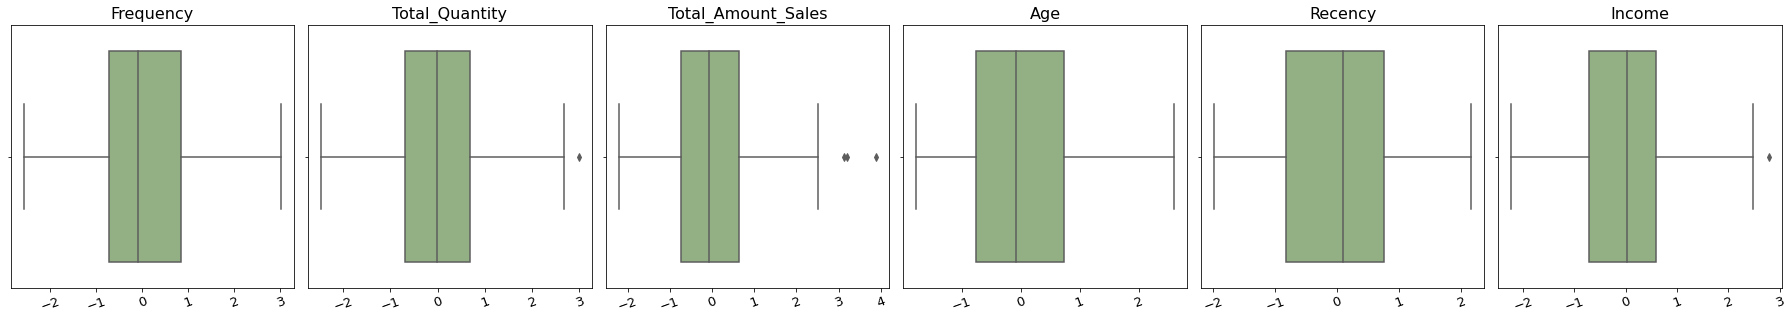

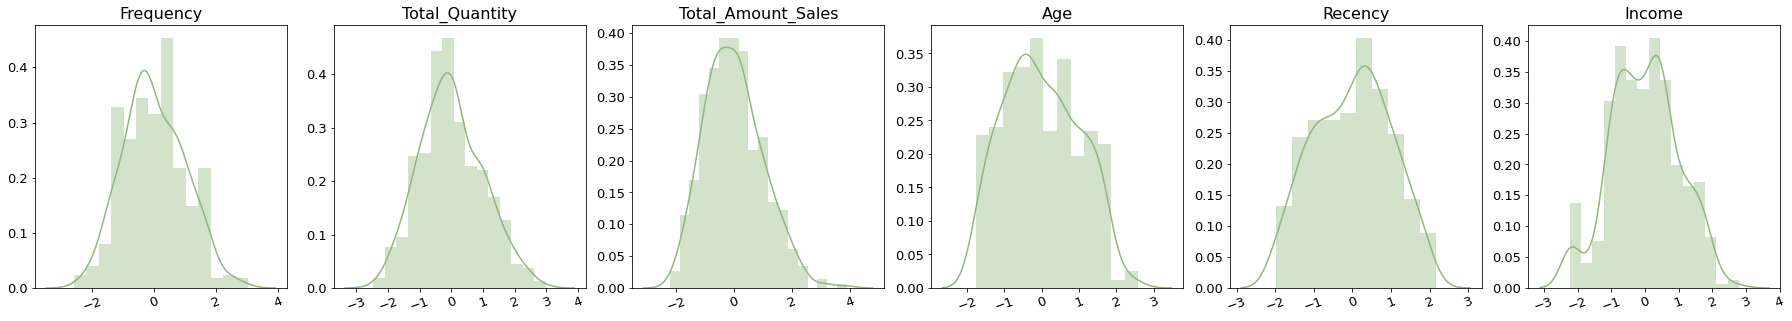

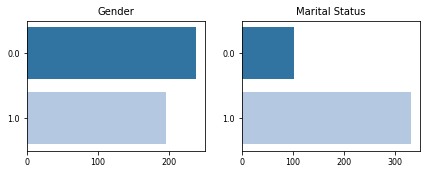

In [26]:
# get preprocessing pipeline by defining our expected features to be preprocessed
pl_preprocessing = get_preprocessing_pipeline(num_1 = ['Frequency', 'Total_Quantity', 'Total_Amount_Sales', 'Age'],
                                              num_2 = ['Recency', 'Income'],
                                              cat = ['Marital Status', 'Gender'], cat_val = [['Single', 'Married'], 
                                                                                             ['Woman', 'Man']])
# fit the pipeline to the input data "df_clustering_no_outliers"
pl_preprocessing.fit(df_clustering_no_outliers)

# do data preprocessing using fitted pipeline "pl_preprocessing" on "df_clustering_no_outliers" 
df_preprocessed = pd.DataFrame(pl_preprocessing.transform(df_clustering_no_outliers), columns = get_feature_names(pl_preprocessing))                               
display(df_preprocessed)

# check data distribution
check_dist_num(df_preprocessed, [col for col in get_feature_names(pl_preprocessing) if col in num])
check_dist_cat(df_preprocessed, cat)

<a name = '4-4'></a>
## Modeling - clustering

From what we saw earlier in hypothesis test, we found that `Marital Status` and `Gender` has no relationship with `Recency`, `Frequency`, `Total_Quantity`, and `Total_Amount_sales`, but they have relationship with `Income` and `Age`. Also the p-corr between the pair of `Marital Status`, `Gender`, `Income` or `Age` is relatively better compared to each of them to `Recency`, `Frequency`, `Total_Quantity`, or `Total_Amount_sales` which is very small.


So here we are going to segment our customers data based on two different things, 
- First of all that based on "behavioral data" (i.g. `Frequency`, `Total_Quantity`, `Total_Amount_Sales`, and `Recency`)
- Secondly based on "demographic data" (i.g. `Age`, `Income`, `Marital Status`, and `Gender`)

In addition, some articles and literatures told me that there are many types of customer segmentation, two of them are customer segmentation based demographic data and based on behavioral data. [[1]](https://www.forbes.com/advisor/business/customer-segmentation/) [[2]](https://openstax.org/books/principles-marketing/pages/5-1-market-segmentation-and-consumer-markets)

Since we have categorical type data in our demographic data (i.e. `Marital Status`, and `Gender`) and K-Means clustering only reasonably works for data in continuous dimensional space (using euclidean distances), we are going to use K-Prototypes clustering which is good for clustering categorical data [[3]](https://github.com/nicodv/kmodes/tree/master). This algorithm can be used for clustering of mixed both numerical and categorical data. In sum, K-Means will be used for "behavioral data" meanwhile K-Prototypes for "demographic data".

In [27]:
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

def PCA_plot(data, clustering_model, k_prot = False, categorical = [], plot_3_PCA = False, plot_3_PCA_as_picture = True):
    """ Function to plot n-dimensional data into lower dimension that is 2-D and 3-D using PCA model.
        Input:
            data                  - Data input which has been cleaned and scaled.
            clustering_model      - Clustering algorithm model given the desired number of clusters.
            k_prot                - Whether the clustering algorithm used K-Prototypes or not.
            categorical           - List containing index of categorical features.
            plot_3_PCA            - Whether we plot the 3-D viz of 3 Principal Components or not.
            plot_3_PCA_as_picture - Whether the 3-D viz using image output as the renderer or not.

        Return:
            None - No output, only visualizations using PCA.
    """
    # fit the data to PCA model
    pca = PCA(n_components = None, random_state = 42)
    pca.fit(data)
    
    # if there is a clustering_model, the plot will show colors representing the clusters
    labels = None
    if clustering_model != None:
        model = clustering_model
        if k_prot == False:
            model.fit(data)
        elif k_prot  == True:
            model.fit(data, categorical = categorical)
        labels = model.labels_
        
    # plot explained variance on PCA model
    fig, ax = plt.subplots(figsize = (8, 4), nrows = 1, ncols = 2)
    df_exp_var = pd.DataFrame(pca.explained_variance_ratio_, index = ['PC{}'.format(ind + 1) for ind in range(pca.n_features_)])
    df_exp_var.plot(kind = 'bar', ax = ax[0], alpha = 0.6)
    df_cumsum_exp_var = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), index = ['PC{}'.format(ind + 1) for ind in range(pca.n_features_)])
    df_cumsum_exp_var.plot(kind = 'line', marker = 'o', ax = ax[0])
    ax[0].set_xlabel('Principle Componenets')
    ax[0].set_ylabel('Percentage of Explained Variance')
    ax[0].set_title('Scree Plot')
    ax[0].legend(['Cumulative Sum Explained Var', 'Explained Var'])

    # plot principle components on 2D: PC1 and PC2
    pca_transformation = pca.transform(data)
    pca_transformation = pd.DataFrame(pca_transformation, columns = ['PC{}'.format(ind + 1) for ind in range(pca.n_features_)])
    sns.scatterplot(data = pca_transformation, x = 'PC1', y = 'PC2', hue = labels, palette = 'viridis', ax = ax[1])
    ax[1].set_title('PC1 and PC2 plot with Total Explained Variance = {:.2f}'.format(df_cumsum_exp_var.iloc[1, :][0]))
    ax[1].axhline(alpha = 0.6, color = 'gray')
    ax[1].axvline(alpha = 0.6, color = 'gray')
    plt.tight_layout()
    plt.show()
    
    # plot principle components on 3D: PC1, PC2, and PC3
    if plot_3_PCA == True:
        fig = px.scatter_3d(pca_transformation, x = 'PC1', y = 'PC2', z = 'PC3', color = labels)
        fig.update_layout(title_text = 'PC1, PC2, and PC3 plot with Total Explained Variance = {:.2f}'.format(df_cumsum_exp_var.iloc[2, :][0]),
                          title_font_size = 12, legend_title_text = 'Clusters')
        if plot_3_PCA_as_picture == True:
            fig.show('png')
        else:
            fig.show()
    return None

def radar_plot(data, segment_name, plot_radar_as_picture = True):
    """ Function to plot in radar plot for interpreting the clustering results.
        Input:
            data                  - Data input which has been unscaled, and has labels from final clustering model.
            segment_name          - The column name containing labels from final clustering model.
            plot_radar_as_picture - Whether the radar viz using image output as the renderer or not.

        Return:
            None - No output, only visualizations using radar plot.
    """
    # prepare the data to be plotted
    data = data.groupby([segment_name]).agg('mean').transform(lambda x: x/x.max()).T
    data = pd.concat([data, data.loc[data.index[0],:].to_frame().T], axis = 0)
    
    # plot using radar plot
    fig = go.Figure()
    for cluster in data.columns:
        fig.add_trace(go.Scatterpolar(r = data[cluster], theta = data.index, name = 'cluster {}'.format(cluster)))                                          
    fig.update_layout(title_text = 'Radar Plot of the resulting {} clusters'.format(len(data.columns)), title_font_size = 13, legend_title_text = 'Clusters')                   
    if plot_radar_as_picture == True:
        fig.show('png')
    else:
        fig.show()
    return None

<a name = '4-4-1'></a>
### Behavioral segmentation

Get the behavioral features for clustering with K-Means alagorithm.

In [28]:
# get the behavioral features
behavioral = ['Frequency', 'Total_Quantity', 'Total_Amount_Sales', 'Recency']
df_preprocessed[behavioral].head()

,Frequency,Total_Quantity,Total_Amount_Sales,Recency
0,1.773511,1.482019,2.083088,0.989894
1,0.528691,1.245034,0.213660,1.783630
2,1.151101,1.166039,0.649860,-0.703350
3,-0.404924,0.376089,-0.513070,-1.214207
4,-1.338539,-1.124817,-0.787415,1.694733


<a name = '4-4-1-1'></a>
#### Find the best number of clusters

Some insights we can get from the **Elbow Plot** and **Silhouette Plot**  below:
- According to Elbow Plot and Silhouette Plot, the recommended number of clusters are `3` or `4`. 
- `2` number of clusters would give us the highest Silhouette Score, but from the Elbow Plot we see that the "elbow" is not located at `2`. It is located between `3` or `4`.
- So we will evaluate `3` and `4` number of clusters.

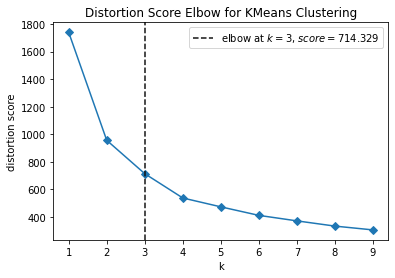

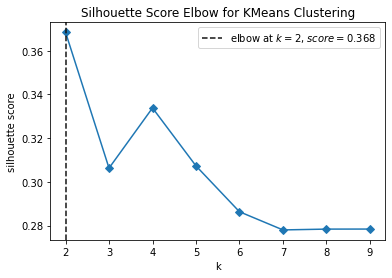

In [29]:
# instantiate the clustering model and visualizer: KMeans
model = KMeans(random_state = 42)

# plot elbow method
viz_distortion = KElbowVisualizer(model, k = (1, 10), metric = 'distortion', timings = False)
viz_distortion.fit(df_preprocessed[behavioral])       
viz_distortion.show()

# plot silhouette method
viz_silhouette = KElbowVisualizer(model, k = (2, 10), metric = 'silhouette', timings = False)
viz_silhouette.fit(df_preprocessed[behavioral])
viz_silhouette.show()
plt.show()

Some insights we can get from the **Silhouette Score of each data points** below:
- For `4` number of clusters, we see that each cluster has roughly equal number of observations/samples compared to `3` number of clusters, meaning that this follows the underlying assumption of K-Means clustering where each cluster should have the same number of samples.
- `4` number of clusters yields greater Silhouette Score than `3`. The greater the Silhouette Score, the better each cluster is made.
- Our final decision will be `4` number of clusters.

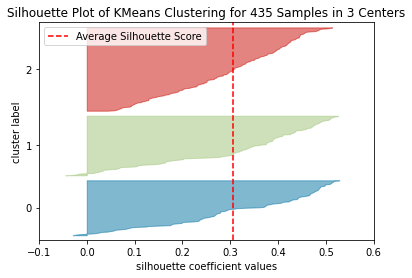

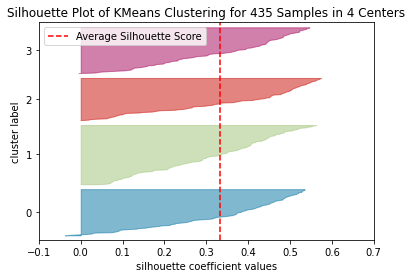

In [30]:
# plot the silhouette score for each data point given the behavioral dataset which has been clustered by n clusters
clusters = [3, 4]
for cluster in clusters:
    model = KMeans(n_clusters = cluster, random_state = 42)
    visualizer = SilhouetteVisualizer(model, colors = 'yellowbrick')
    visualizer.fit(df_preprocessed[behavioral])
    visualizer.show()

Some insights we can get from the **PCA** below:
- The explained variance of a principal component is a measure of how much information or variability from the original data is retained in that component. Total explained variance by using `PC1` and `PC2` is 94% which is very good since we can preserve up to 90% of variability information in the data.
- No overlapping clusters are made with 4 clusters given.

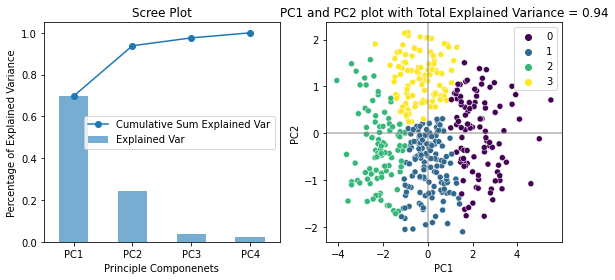

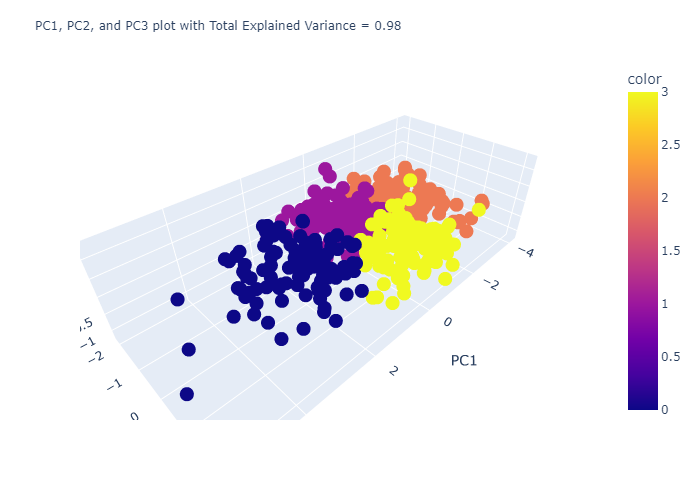

In [31]:
# do PCA to evaluate the clusters
PCA_plot(data = df_preprocessed[behavioral], 
         clustering_model = KMeans(n_clusters = 4, random_state = 42),
         plot_3_PCA = True, plot_3_PCA_as_picture = True)

<a name = '4-4-1-2'></a>
#### Build and interpret clustering model

The final number of clusters used is `4`. Hence we build KMeans clustering on behavioral data with `4` clusters.

In [32]:
# build KMeans with 4 clusters for behavioral data
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(df_preprocessed[behavioral])

# assign the clusters to unscaled data: df_behavioral
df_behavioral = df_clustering_no_outliers[behavioral]
df_behavioral['Behavioral_Segmentation'] = kmeans.labels_
df_behavioral.head()

,Frequency,Total_Quantity,Total_Amount_Sales,Recency,Behavioral_Segmentation
CustomerID,,,,,
1,17,60,623300,53,0
2,13,57,392300,97,1
3,15,56,446200,10,0
4,10,46,302500,5,3
5,7,27,268600,91,2


Some insights we can get:
- We see that the behavioral traits for each cluster are different from each other. 
- We can segment our customers based on their behavior into 4 clusters:
    1. `Cluster 0`: `Diamond` customer segment. They have spent the most in term of quantity and total amount sales, the most frequent buyers, and have purchased quite recently. This is the best customers so far.
    2. `Cluster 1`: `Gold` customer segment. They have spent the second most quantity and total amount sales, the second most frequent buyers, BUT have purchased a long time ago. They are basically near `Diamond` customers level but haven't purchased anything for a long time. This customers almost got churned.
    3. `Cluster 2`: `Lost` customer segment. They have spent the least in term of quantity and total amount sales. The least frequent buyers, and also haven't purchased anything long time ago. This is most likely the churned customers.
    4. `Cluster 3`: `Potential` customer segment. They have quite good spending in term of quantity and total amount sales, quite purchase frequently, and the most recent buyers. This customers have a lot of potential to improve into `Diamond` level.

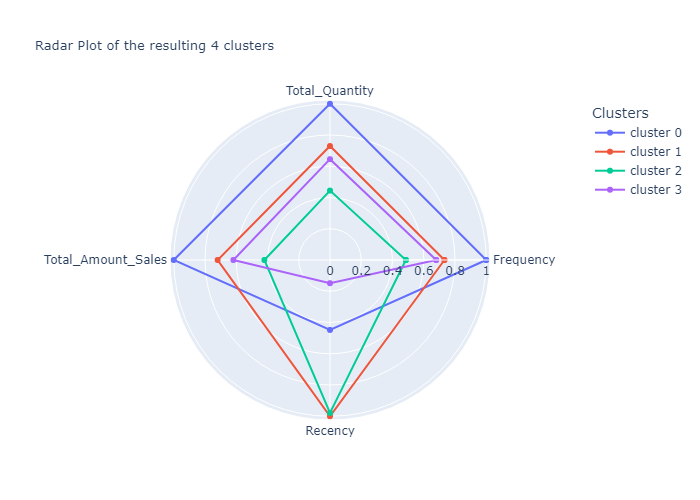

Recency Frequency Total_Quantity Total_Amount_Sales  \
                           mean      mean           mean               mean   
Behavioral_Segmentation                                                       
Diamond                   20.42     15.48          57.92          524915.38   
Gold                      45.63     11.34          42.26          377484.96   
Potential                  6.78     10.52          37.38          324564.08   
Lost                      44.65      7.52          25.74          220411.58   

                               
                        count  
Behavioral_Segmentation        
Diamond                   104  
Gold                      133  
Potential                 103  
Lost                       95

In [33]:
# interpret each cluster
radar_plot(df_behavioral, segment_name = 'Behavioral_Segmentation') # using radar plot
df_behavioral_centroids = df_behavioral.groupby(['Behavioral_Segmentation']).agg({'Recency':'mean',
                                                                                  'Frequency':'mean',
                                                                                  'Total_Quantity':'mean',
                                                                                  'Total_Amount_Sales':['mean', 'count']}).round(2) # using mean aggregatation

# assign the cluster name
map_behavioral = {0:'Diamond', 1:'Gold', 2:'Lost', 3:'Potential'}
df_behavioral_centroids = df_behavioral_centroids.rename(map_behavioral, axis = 0)
df_behavioral_centroids.sort_values(by = ('Total_Amount_Sales', 'mean'), ascending = False)

<a name = '4-4-2'></a>
### Demographic segmentation

Get the demographic features for clustering with K-Prototypes alagorithm.

In [34]:
# get the demographic features
demographic = ['Age', 'Income', 'Marital Status', 'Gender']
df_preprocessed[demographic].head()

,Age,Income,Marital Status,Gender
0,1.218149,-0.492632,1.0,1.0
1,1.621540,-0.245929,1.0,1.0
2,-0.637451,0.323560,1.0,1.0
3,-0.718129,-0.551401,1.0,1.0
4,1.460184,-0.880941,1.0,1.0


<a name = '4-4-2-1'></a>
#### Find the best number of clusters

Some insights we can get from the **Elbow Plot** and **Silhouette Plot**  below:
- According to Elbow Plot and Silhouette Plot, the recommended number of clusters are `3` or `4`. 
- As the same as the previous behavioral clustering case, `2` number of clusters would give us the highest Silhouette Score and also `7` number of clusters is the second highest, but from the Elbow Plot we see that the "elbow" is not located at there. It is relatively located between `3` or `4`.
- So we will evaluate `3` and `4` number of clusters.

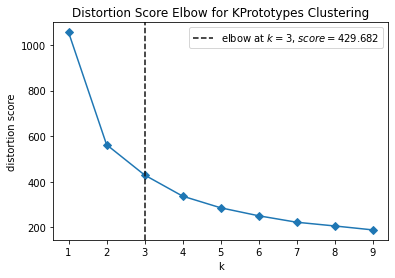

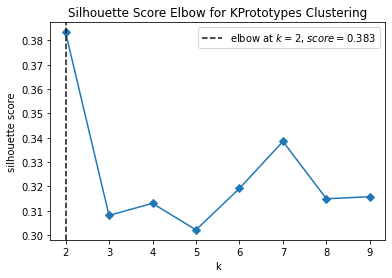

In [35]:
# instantiate the clustering model and visualizer: KPrototypes
model = KPrototypes(init = 'Huang', random_state = 42, max_iter = 250, n_jobs = -1)

# plot elbow method
viz_distortion = KElbowVisualizer(model, k = (1, 10), metric = 'distortion', timings = False)
viz_distortion.fit(df_preprocessed[demographic], categorical = [2, 3])       
viz_distortion.show()

# plot silhouette method
viz_silhouette = KElbowVisualizer(model, k = (2, 10), metric = 'silhouette', timings = False)
viz_silhouette.fit(df_preprocessed[demographic], categorical = [2, 3])
viz_silhouette.show()
plt.show()

Some insights we can get from the **PCA** below:
- Total explained variance by using `PC1` and `PC2` is 85% which is quite good enough.
- There seems to be few overlapped data points.

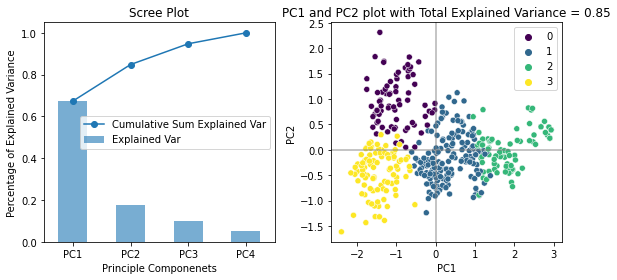

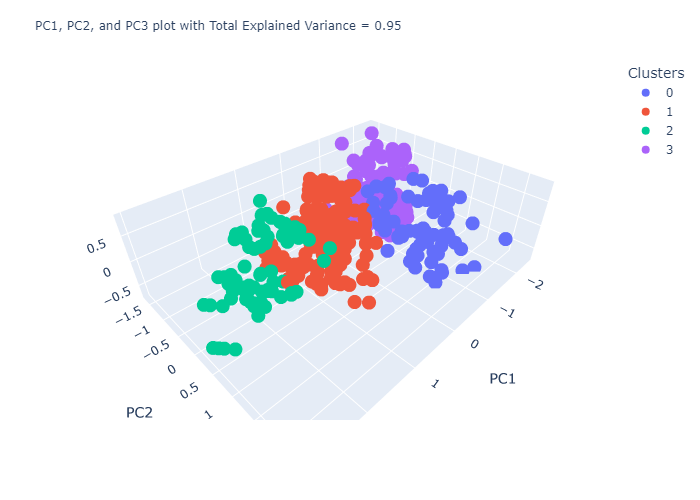

In [36]:
# do PCA to evaluate the clusters
PCA_plot(data = df_preprocessed[demographic], 
         clustering_model = KPrototypes(n_clusters = 4, init = 'Huang', random_state = 42, max_iter = 250, n_jobs = -1),
         k_prot = True, categorical = [2, 3],
         plot_3_PCA = True, plot_3_PCA_as_picture = True)

<a name = '4-4-2-2'></a>
#### Build and interpret clustering model

The final number of clusters used is `4`. Hence we build K-Prototypes clustering on demographic data with `4` clusters.

In [37]:
# build KPrototypes with 4 clusters for demographic data
kprototypes = KPrototypes(n_clusters = 4, init = 'Huang', random_state = 42, max_iter = 250, n_jobs = -1)
kprototypes.fit(df_preprocessed[demographic], categorical = [2, 3])

# assign the clusters to unscaled data: df_demographic
df_demographic = df_clustering_no_outliers[demographic]
df_demographic['Demographic_Segmentation'] = kprototypes.labels_

# Encode 'Gender' and 'Marital Status' into numerical
df_demographic['Marital Status'] = df_demographic['Marital Status'].replace({'Married':1, 'Single':0})
df_demographic['Gender'] = df_demographic['Gender'].replace({'Man':1, 'Woman':0})
df_demographic.head()

,Age,Income,Marital Status,Gender,Demographic_Segmentation
CustomerID,,,,,
1,55,5.12,1,1,0
2,60,6.23,1,1,0
3,32,9.17,1,1,1
4,31,4.87,1,1,1
5,58,3.57,1,1,0


Some insights we can get:
- We see that the demographic traits for each cluster are different from each other. 
- We can segment our customers based on their demographic into 4 clusters:
    1. `Cluster 0`: `Senior` customer segment. They are elder customers having been married with medium income. Most of them are Man. Most likely they are retired worker.
    2. `Cluster 1`: `Middle-Adult` customer segment. Their age is within 30-40 years old, having been married with medium income. Most of them are Woman.
    3. `Cluster 2`: `Young-Adult` customer segment. They are most likely teenager with range 20-30 years old, which are most likely single and low income. Most of them are Man.
    3. `Cluster 3`: `Late-Adult` customer segment. They are in mature age within 40-55 years old, having been married with high income. Most of them are Woman.

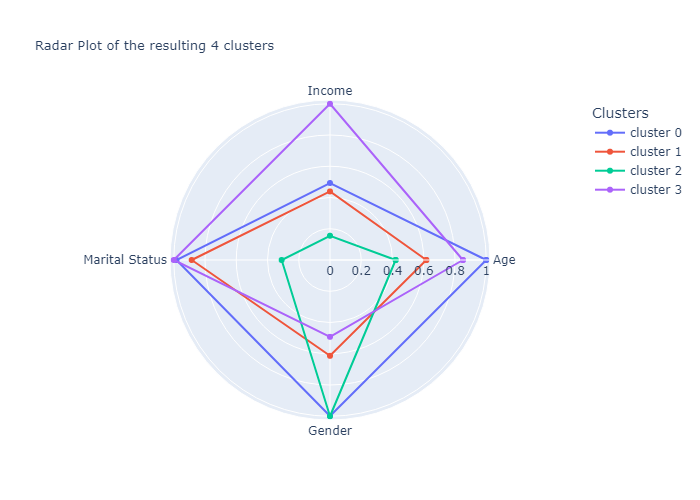

Age Income Marital Status Gender      
                           mean   mean           mean   mean count
Demographic_Segmentation                                          
Senior                    57.03   7.82           0.92   0.62    78
Late-Adult                48.51  15.86           0.94   0.30    99
Middle-Adult              35.16   6.96           0.83   0.38   172
Young-Adult               23.95   2.46           0.29   0.62    86

In [38]:
# interpret each cluster
radar_plot(df_demographic, segment_name = 'Demographic_Segmentation') # using radar plot
df_demographic_centroids = df_demographic.groupby(['Demographic_Segmentation']).agg({'Age':'mean',
                                                                                     'Income':'mean',
                                                                                     'Marital Status':'mean',
                                                                                     'Gender':['mean', 'count']}).round(2) # using mean aggregatation

# assign the cluster name
map_demographic = {0:'Senior', 1:'Middle-Adult', 2:'Young-Adult', 3:'Late-Adult'}
df_demographic_centroids = df_demographic_centroids.rename(map_demographic, axis = 0)
df_demographic_centroids.sort_values(by = ('Age', 'mean'), ascending = False)

<a name = '4-5'></a>
## Assign the results to customer dataset

We have built and trained two types of customer segmentation, using K-Means for "Behavioral data" and using K-Prototypes for "Demographic data". Both model are stored in `kmeans` and `kprototypes` variables respesctively. Now let's predict the segment of customers in the original dataset, `df_clustering`. (previously we trained our model using data from `df_clustering_no_outliers` which have been done outliers removal)

In [39]:
# preprocess 'df_clustering' which is the original customer data (without outliers removal)
df_preprocessed_2 = pd.DataFrame(pl_preprocessing.transform(df_clustering), columns = get_feature_names(pl_preprocessing))

# assign the clusters into original customer data
customer_clustering = df_clustering.copy()
customer_clustering['Behavioral_Segmentation'] = kmeans.predict(df_preprocessed_2[behavioral])
customer_clustering['Demographic_Segmentation'] = kprototypes.predict(df_preprocessed_2[demographic], categorical = [2, 3])

# map the cluster labels
customer_clustering['Behavioral_Segmentation'] = customer_clustering['Behavioral_Segmentation'].map(map_behavioral)
customer_clustering['Demographic_Segmentation'] = customer_clustering['Demographic_Segmentation'].map(map_demographic)

# save the clustering results to new .csv file
customer_clustering.reset_index().to_csv('dataset/customer_clustering.csv', sep = ';', index = False)
store.to_csv('dataset/store.csv', sep = ';', index = False)

display(customer_clustering)

,Frequency,Total_Quantity,Total_Amount_Sales,Recency,Age,Gender,Marital Status,Income,Behavioral_Segmentation,Demographic_Segmentation
CustomerID,,,,,,,,,,
1,17,60,623300,53,55,Man,Married,5.12,Diamond,Senior
2,13,57,392300,97,60,Man,Married,6.23,Gold,Senior
3,15,56,446200,10,32,Man,Married,9.17,Diamond,Middle-Adult
4,10,46,302500,5,31,Man,Married,4.87,Potential,Middle-Adult
5,7,27,268600,91,58,Man,Married,3.57,Lost,Senior
...,...,...,...,...,...,...,...,...,...,...
443,16,59,485100,63,33,Man,Married,9.28,Diamond,Middle-Adult
444,18,62,577700,38,53,Woman,Married,15.31,Diamond,Late-Adult
445,18,68,587200,42,51,Woman,Married,14.48,Diamond,Late-Adult


<a name = '4-6'></a>
## Dashbord - Sales Analysis by Customer Segmentation

The result of this clustering model can be used to make decision about how to treat each of our customer diffrenetly based on their similar characteristics.

You can see fully the dashboard of sales analysis by customer segmentation on Tableau Public via this [link](https://public.tableau.com/shared/CG5HZHQRK?:display_count=n&:origin=viz_share_link).

<img src="image/sales analysis dashboard.png" width="1100">

<a name = '5'></a>
# Forecasting

<a name = '5-1'></a>
## Daily quantity dataset

As mentioned in the background story, we will create forecasting for daily quantity of all product hence we will create the dataset first. Note that our joined and cleaned transaction dataset has been stored in `df` variable.

In [40]:
df

,TransactionID,CustomerID,Age,Gender,Marital Status,Income,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,ProductID,Product Name,Price,Qty,TotalAmount
Date,,,,,,,,,,,,,,,,,
2022-01-01,TR11369,328,36,0,Married,10.53,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,P3,Crackers,7500,4,30000
2022-01-01,TR16356,165,44,1,Married,14.58,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,P9,Yoghurt,10000,7,70000
2022-01-01,TR1984,183,27,1,Single,0.18,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,P1,Choco Bar,8800,4,35200
2022-01-01,TR35256,160,48,1,Married,12.57,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,P1,Choco Bar,8800,7,61600
2022-01-01,TR41231,386,33,0,Married,6.95,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,P9,Yoghurt,10000,1,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,TR54423,243,38,0,Married,3.34,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529,P10,Cheese Stick,15000,5,75000
2022-12-31,TR5604,271,29,0,Married,4.74,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,P2,Ginger Candy,3200,4,12800
2022-12-31,TR81224,52,37,0,Married,3.73,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,P7,Coffee Candy,9400,6,56400


,Total_Quantity
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


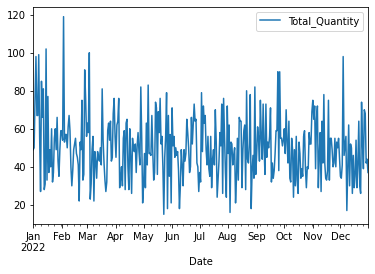

In [41]:
df_daily = df.resample('D').agg({'Qty':'sum'}).rename({'Qty':'Total_Quantity'}, axis = 1)
df_daily.plot()
display(df_daily)
plt.show()

<a name = '5-2'></a>
## Check for stationarity

ARIMA model relies on stationary time-series where stationary time series dataset will have some criteria such as constant mean, variance, and covariance in other words the distribution of the data are independent with time. We can use hypothesis testing to check for stationarity.

First of all, we will use the Augmented Dicky-Fuller (ADF) test, having hypotheses like below.
- Null hypothesis ($H_0$) is time series is non-stationary.
- Alternate hypothesis ($H_1$) is time series is stationary.

Secondly, we will use the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, having hypotheses like below.
- Null hypothesis ($H_0$) is time series is stationary.
- Alternate hypothesis ($H_1$) is time series is non-stationary.

If the p-values below the significance ($\alpha = 0.05$), we reject $H_0$, and otherwise is stationary.

*Note that the $H_0$ and $H_1$ is reversed in the KPSS test compared to ADF Test*.

In [42]:
def hypothesis_testing(input_data, sig_level = 0.05):
    from statsmodels.tsa.stattools import kpss, adfuller    
    result_1 = adfuller(input_data)
    result_2 = kpss(input_data)
    print('adfuller test:\np-values: {}'.format(result_1[1]))
    if result_1[1] < sig_level:
        print('Reject H0 ---> time series is stationary')
    else:
        print('Accept H0 ---> time series is non-stationary')
        
    print('\nKPSS test:\np-values: {}'.format(result_2[1]))
    if result_2[1] < sig_level:
        print('Reject H0 ---> time series is non-stationary')
    else:
        print('Accept H0 ---> time series is stationary')

In [43]:
hypothesis_testing(df_daily, sig_level = 0.05)

adfuller test:
p-values: 0.0
Reject H0 ---> time series is stationary

KPSS test:
p-values: 0.06622747821677664
Accept H0 ---> time series is stationary


<a name = '5-3'></a>
## Define the best p and q parameters

When fitting the time-series into ARIMA model, we need to define first the lag parameter values (`p` and `q`) in `AR(p)` and `MA(q)` components in order to get optimal value of evaluation metric. We can use ACF and PACF plots to determine the best candidate values.

In [44]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
def plot_autocor(input_data, lags_acf, lags_pacf, zero_lag = False):
    fig, ax = plt.subplots(figsize = (6, 5), nrows = 2)
    plot_acf(input_data, zero = zero_lag, lags = lags_acf, ax = ax[0])
    plot_pacf(input_data, zero = zero_lag, lags = lags_pacf, ax = ax[1])
    plt.tight_layout()
    plt.show()

From the ACF and PACF plots below, 
- We have some insignificant autocorrelation values. 
- This is called as "White Noise", This condition happens when our data is stationary but the autocorrelations are zero at all lags.
- Transforming the data might overcome this issue.

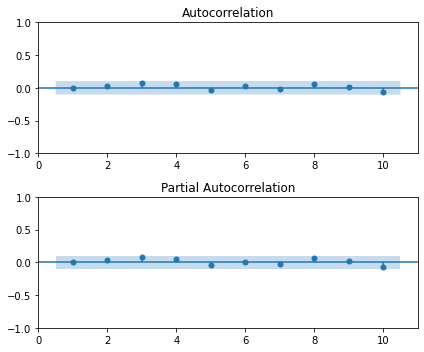

In [45]:
# plot ACF and PACF
plot_autocor(df_daily, 10, 10)

From the ACF and PACF plots below,
- As we can see by taking the difference, the autocorrelations are not zero anymore.
- We will choose the `d` = `2`.
- `p` = `1` to `4`
- `q` = `1` to `2`

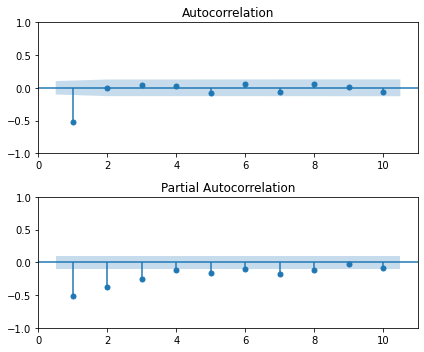

adfuller test:
p-values: 6.148467265279569e-21
Reject H0 ---> time series is stationary

KPSS test:
p-values: 0.1
Accept H0 ---> time series is stationary


c:\users\tito\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [46]:
# plot ACF and PACF
plot_autocor(df_daily.diff(1).dropna(), 10, 10)
hypothesis_testing(df_daily.diff(1).dropna(), sig_level = 0.05)

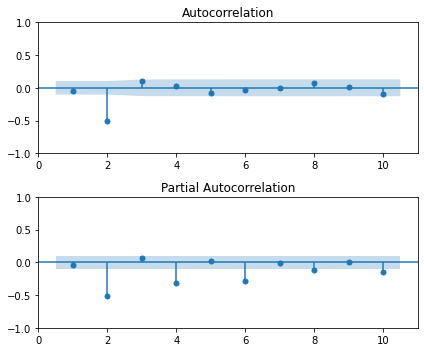

adfuller test:
p-values: 3.4821335991476044e-11
Reject H0 ---> time series is stationary

KPSS test:
p-values: 0.1
Accept H0 ---> time series is stationary


c:\users\tito\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [47]:
# plot ACF and PACF
plot_autocor(df_daily.diff(2).dropna(), 10, 10)
hypothesis_testing(df_daily.diff(2).dropna(), sig_level = 0.05)

<a name = '5-4'></a>
## Choose the best model using grid search

In [48]:
import pmdarima as pm
results = pm.auto_arima(df_daily, 
                        d = 2, start_p = 2, start_q = 2,
                        max_d = 2, max_p = 6, max_q = 2,
                        trace = True, information_criterion = 'aic')

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3731.707, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3518.903, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3401.324, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=3319.933, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=3287.880, Time=0.11 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=3259.857, Time=0.08 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=3249.721, Time=0.16 sec
 ARIMA(6,2,1)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=3251.685, Time=0.39 sec

Best model:  ARIMA(6,2,0)(0,0,0)[0]          
Total fit time: 3.121 seconds


<a name = '5-5'></a>
## Build the model

We found that the best model is `ARIMA(6,2,0)`. Let's build this model.

In [49]:
# build ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_daily, order = (6,2,0))
result = model.fit()

<a name = '5-6'></a>
## Visualize the result

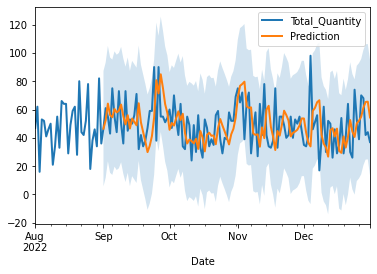

In [50]:
pred = result.get_prediction(start = pd.to_datetime('2022-09-01'), dynamic = False)
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean

fig, ax = plt.subplots()
df_daily.loc['2022-08-01':].plot(label='observed', linewidth=2, ax = ax)
pred.predicted_mean.to_frame('Prediction').plot(ax=ax, label='One-step ahead Forecast', linewidth=2)
ax.fill_between(pred_ci.index, pred_ci['lower Total_Quantity'], pred_ci['upper Total_Quantity'], alpha=0.2)
plt.show()

In [51]:
# calculate performance metric
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = df_daily.values
y_pred = result.get_prediction(start = df_daily.index[0], dynamic = False).predicted_mean.values

MAE = mean_absolute_error(y_true, y_pred)
RMSE = mean_squared_error(y_true, y_pred, squared = False)
print('MAE: {:.2f} units'.format(MAE))
print('RMSE: {:.2f} units'.format(RMSE))

MAE: 16.84 units
RMSE: 21.01 units


<a name = '5-7'></a>
## Predict the future

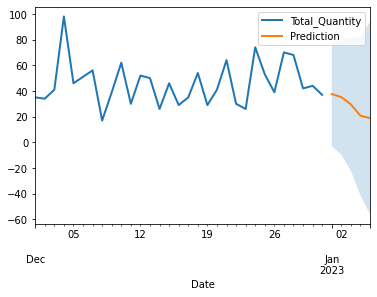

,Prediction
2023-01-01,37.606836
2023-01-02,35.212744
2023-01-03,29.564290
2023-01-04,20.710638
2023-01-05,18.881172


In [52]:
# Predict 5 days later from 2022-12-31
pred = result.get_forecast(steps = 5, dynamic = False)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

fig, ax = plt.subplots()
df_daily.loc['2022-12-01':].plot(label='observed', linewidth=2, ax = ax)
pred_mean.to_frame('Prediction').plot(ax=ax, label='One-step ahead Forecast', linewidth=2)
ax.fill_between(pred_ci.index, pred_ci['lower Total_Quantity'], pred_ci['upper Total_Quantity'], alpha=0.2)
plt.show()

display(pred_mean.to_frame('Prediction'))

<a name = '6'></a>
# Recommendations

Behavioral Segmentation

- Diamond customer segment. (Focus on increasing frequency and retention)
    - Loyalty programs and give rewards/promo to make them feel respected, 
    - Market most expensive products, 
    - Offer new products, and cross-selling/up-selling strategy.
- Gold customer segment. (Focus on maintaining their loyalty and improve their value )
    - Offer them a discount, free trial, or another incentive.
    - Make limited time offers.

- Lost customer segment. (Focus on reactivating the customer)
    - Reactivation strategy such as send them reactivation emails and ask them for feedback.
    - Provide support.

- Potential customer segment. (Focus on increasing their value)
    - Cross-selling/up-selling strategy, give price incentives and new products recomendation.
    
    
Demographic Segmentation
- Adjust pricing strategies based on income levels.
- Adapt products or services to satisfy to the needs and preferences of different demographic segments.

<a name = '7'></a>
# References

1. [Customer Segmentation: The Ultimate Guide](https://www.forbes.com/advisor/business/customer-segmentation/)
2. [Market Segmentation and Consumer Markets - Openstax](https://openstax.org/books/principles-marketing/pages/5-1-market-segmentation-and-consumer-markets)
3. [python kmodes library](https://github.com/nicodv/kmodes/tree/master)
4. [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
5. [ARIMA & SARIMA: Real-World Time Series Forecasting](https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide)